# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021-2022. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet.
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [ ]:
! wget http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SCL-OPP.zip

--2023-05-23 19:21:24--  http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SCL-OPP.zip
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15221 (15K) [application/zip]
Saving to: ‘SCL-OPP.zip’

SCL-OPP.zip         100%[===================>]  14.86K  65.3KB/s    in 0.2s    

2023-05-23 19:21:25 (65.3 KB/s) - ‘SCL-OPP.zip’ saved [15221/15221]



In [ ]:
!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,050 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,345 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Ge

In [ ]:
import zipfile
with zipfile.ZipFile('data/SCL-OPP.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import gensim
import string
import re
import nltk
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from yellowbrick.features.manifold import manifold_embedding
from yellowbrick.classifier import classification_report, confusion_matrix
import enchant

nltk.download('stopwords')
nltk.download('punkt')
is_english = enchant.Dict("en_US").check

df  = pd.read_parquet('https://github.com/omriallouche/ydata_deep_learning_2021/raw/master/data/metrolyrics.parquet')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stops = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# filter our non english songs
word_split = df['sent'].str.split(' ')
first_word_english = word_split.str[0].map(is_english)
last_word_english = word_split.str[-1].map(is_english)
df = df[first_word_english & last_word_english]

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [ ]:
# Set retrain to True to re run saved output
retrain = False
model_name = "lyrics4"

if retrain:
    assert gensim.models.doc2vec.FAST_VERSION > -1

    clean_sentences = (df['lyrics']
                .str.strip()
                .map(tokenizer.tokenize) # seperates to sentences
                .explode() # sentence per row
                .map(lambda sentence: BeautifulSoup(sentence, 'html').get_text()) # extract non-html text from every sentence
                )

    very_clean_words = (
        clean_sentences
            .str.lower()
            .map(nltk.tokenize.word_tokenize) # separate to words
            .explode() # word per row
            .pipe(lambda words: words[~words.isin(stops | set(string.punctuation))])  # get rid of rows with only stopwords and punctuations
            .str.replace('[^a-z]', '', regex=True) # make sure there aren't any characters that the toenizer skips
            .pipe(lambda words: words[words.str.len().gt(1)])  # get rid of rows with only stopwords and punctuations, or 1 letter
    )

    very_clean_sentences = (
        very_clean_words
        .groupby(level=0).agg(list) # return to sentence per row
    )

    clean_sentences.to_frame().to_parquet('data/clean_sentences.pqt')
    very_clean_words.to_frame().to_parquet('data/very_clean_words.pqt')
    very_clean_sentences.to_frame().to_parquet('data/very_clean_sentences.pqt')

    model = Word2Vec(very_clean_sentences, vector_size=300, window=5, min_count=10, workers=2, sg=1) # min count as a rare words filter (assuming I'm not interested in an external list)
    model.save(f'data/{model_name}.w2v')
else:
    model = gensim.models.Word2Vec.load(f'data/{model_name}.w2v')
    clean_sentences = pd.read_parquet('data/clean_sentences.pqt').squeeze()
    very_clean_words = pd.read_parquet('data/very_clean_words.pqt').squeeze()
    very_clean_sentences = pd.read_parquet('data/very_clean_sentences.pqt').squeeze()

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text.

Choose words yourself, and find the most similar words to them.

In [ ]:
model.wv.most_similar(positive=['lil'], topn=3)

[('jon', 0.5886737108230591),
 ('keke', 0.5698381066322327),
 ('twurk', 0.5610568523406982)]

In [ ]:
model.wv.most_similar(positive=['love'], topn=3)

[('togetherness', 0.5905840396881104),
 ('roni', 0.5899755954742432),
 ('overprotected', 0.5660878419876099)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ).

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [ ]:
pos = model.wv['ice'] - model.wv['water'] + model.wv['expensive']

model.wv.similar_by_vector(pos, topn=10)

[('ice', 0.6743409037590027),
 ('expensive', 0.5415271520614624),
 ('karats', 0.40754246711730957),
 ('bezel', 0.40594053268432617),
 ('jewelry', 0.3982243239879608),
 ('jeweler', 0.3915306031703949),
 ('tq', 0.3885830044746399),
 ('rolex', 0.3868626356124878),
 ('icey', 0.38355737924575806),
 ('pinky', 0.38188934326171875)]

In [ ]:
np.linalg.norm((model.wv['ice'] - model.wv['water'] + model.wv['expensive']) - model.wv['rolex'])

5.9978466

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a regressor to predict the sentiment score of a word given its word vector (the vector you computed using the song lyrics dataset), in range -1 to 1. Split the data to a train and test sets, and report the model performance on both sets.

In [ ]:
lexicon = pd.read_csv('SCL-OPP/SCL-OPP.txt', delimiter='\t', names=['term','score','pos','freq'])

emb = {model.wv.index_to_key[i] : model.wv[i] for i in range(len(model.wv))}
emb = pd.DataFrame.from_dict(emb, orient='index')

temb = lexicon.merge(emb, left_on='term', right_index=True).sort_values('score')

In [ ]:
from sklearn.metrics import mean_squared_error
temb['score_quants'] = pd.qcut(temb['score'], 50)

X_train, X_test, y_train, y_test = train_test_split(temb[list(range(300))], temb['score'], stratify=temb['score_quants'], train_size=0.8)

reg = Ridge().fit(X_train, y_train)
pred = reg.predict(X_test)
pred_train = reg.predict(X_train)

print(f'MAE test: {mean_absolute_error(y_test, pred)}, MAE train: {mean_absolute_error(y_train, pred_train)}')
print(f'MSE test: {mean_squared_error(y_test, pred)}, MSE train: {mean_squared_error(y_train, pred_train)}')

MAE test: 0.3917227633847847, MAE train: 0.1669865356223578
MSE test: 0.2331357515535497, MSE train: 0.046779006738558386


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [ ]:
not_in_lyrics  = emb[~emb.index.isin(temb['term'])].copy()
not_in_lyrics['sentiment_pred'] = reg.predict(not_in_lyrics[range(300)])
not_in_lyrics['sentiment_pred'].sort_values(key=np.abs).tail(40)

conversation    1.208931
bethlehem       1.211062
cure           -1.213015
remorse        -1.216394
drown          -1.217529
kissin          1.222289
bye             1.234843
vibe            1.236805
charms          1.239880
rome            1.239980
es              1.247253
searchin        1.257617
chaos          -1.257713
skull          -1.263554
idea            1.269063
jubilee         1.281064
soda           -1.282237
everythin       1.295709
deadly         -1.303977
oo              1.309146
tick           -1.325185
bleed          -1.331205
tidings         1.346021
jesus           1.365342
sheep          -1.392908
joy             1.395738
bones          -1.421014
rotting        -1.441245
hollow         -1.450281
violence       -1.452558
together        1.462676
lets            1.482782
grateful        1.497952
lalala          1.514102
vegas           1.527781
miami           1.535826
victims        -1.551062
lift            1.605795
gentlemen       1.643443
ooh             1.864096


### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words.
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. You are encouraged to try that color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [ ]:
emb['count'] = emb.index.map(lambda w: model.wv.get_vecattr(w, "count"))
emb_freq = emb.nlargest(3000, 'count')
emb_freq['general_freq'] = emb_freq['count'] / emb_freq['count'].sum()
emb_freq

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,count,general_freq
nt,0.024208,-0.012703,0.075198,-0.084691,0.162003,-0.008554,0.016335,0.150041,0.032959,-0.185958,...,0.030102,-0.060388,0.168790,-0.074804,0.140802,-0.017890,0.140426,-0.116227,134353,0.029008
like,0.128370,-0.015013,0.134019,-0.037360,0.187493,0.189155,0.191741,0.239964,0.143833,-0.133192,...,-0.072465,0.155251,0.098079,0.012413,-0.043567,-0.051130,0.001202,-0.064477,60597,0.013083
know,0.210103,-0.037401,0.102505,0.010342,0.170304,0.133862,-0.061585,0.189921,0.116167,-0.090339,...,0.119652,0.103877,0.169554,0.128982,0.110786,0.042516,0.041864,0.009766,55251,0.011929
love,0.230955,-0.116907,0.186527,-0.061516,0.129770,0.074433,-0.239088,0.197022,0.195360,-0.277443,...,-0.049663,0.036038,0.160056,-0.104537,-0.093457,0.069856,0.380615,-0.121102,54512,0.011770
got,0.074102,0.039598,0.146351,-0.024650,0.303756,0.141901,-0.007370,0.330842,0.269276,-0.224471,...,0.384606,0.099114,0.240211,0.143793,0.054265,0.191792,0.083347,0.116149,51923,0.011211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
parade,-0.223176,0.132479,-0.249393,0.244455,-0.116762,0.131406,-0.192882,0.218473,0.129583,-0.329281,...,-0.059354,0.001591,-0.077900,-0.107267,-0.013288,0.094238,0.200771,0.207289,185,0.000040
wandering,-0.079771,-0.224919,-0.137219,-0.160439,-0.015431,0.143667,0.025798,0.406993,-0.003170,-0.014422,...,-0.161222,-0.055779,0.018740,0.189092,-0.064630,0.241679,0.113538,-0.161099,184,0.000040
sleeps,-0.058006,0.131773,0.187662,0.216326,0.111527,0.120858,0.195675,0.168538,0.451241,-0.160000,...,-0.233938,0.176237,0.200077,-0.413116,-0.033435,-0.109031,0.036175,0.132741,184,0.000040
searchin,0.145931,-0.287320,0.055242,-0.304460,0.401638,-0.128779,-0.154425,-0.022942,-0.156524,0.249436,...,0.213956,0.028058,-0.059922,0.322501,-0.025874,-0.018899,0.005860,0.043717,184,0.000040


In [ ]:
freq_per_genre = (df[['genre']]
                  .join(very_clean_words[very_clean_words.isin(emb_freq.index)], how='left') # genre per word in song
                  .groupby('genre').value_counts(normalize=True) # word_rate_per_genre
                  .unstack('genre') # reshape and stuff
                  .fillna(0))

freq_per_genre = freq_per_genre.div(emb_freq['general_freq'], axis=0)
freq_per_genre

genre,Country,Hip-Hop,Metal,Pop,Rock
aah,1.008124,0.654242,0.300467,1.867759,1.142208
able,0.693685,1.029825,1.574950,0.830640,0.956167
accept,0.351992,0.739105,2.545813,0.816687,1.065906
ace,0.986629,1.814952,0.495547,0.335935,0.632321
aching,1.721461,0.254882,1.227104,0.998527,1.654904
...,...,...,...,...,...
youth,0.828102,1.003171,1.802804,0.496493,1.116249
yuh,0.000000,2.934578,0.048544,0.020372,0.000000
yup,0.373922,2.663915,0.083585,0.175384,0.019257
zero,0.400631,0.984139,1.497557,1.074230,1.035067


In [ ]:
top_50_per_genre = freq_per_genre.stack().groupby('genre').nlargest(50).reset_index(level=2, drop=True)
top_50_per_genre

genre             
Country  tennessee    5.564320
         lonesome     5.508676
         cowboy       5.369080
         rodeo        4.978996
         ole          4.795986
                        ...   
Rock     lazy         1.704150
         angry        1.703293
         mistakes     1.700452
         asleep       1.700196
         rescue       1.699548
Length: 250, dtype: float64

In [ ]:
top_50_all_genres_emb = emb.loc[top_50_per_genre.index.get_level_values(level=1)]
top_50_all_genres_emb

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,count
tennessee,0.271471,0.038291,0.200129,-0.199260,-0.622353,0.077345,-0.296615,0.092829,-0.029151,0.329840,...,0.217868,-0.121936,-0.221971,0.314323,-0.282424,-0.265177,-0.016238,-0.121010,-0.163486,198
lonesome,0.013258,-0.010667,0.068849,0.030289,0.255395,0.342415,-0.390331,0.409746,0.111523,-0.292192,...,-0.126903,0.281317,0.019763,0.207664,-0.136742,-0.125267,-0.106741,0.205534,-0.022846,648
cowboy,-0.178450,0.423191,0.467602,-0.041640,0.093395,-0.073703,0.026661,-0.090826,0.297387,0.044248,...,-0.113530,0.225234,-0.214728,0.469187,0.332859,-0.017719,-0.645108,0.214547,0.413073,513
rodeo,-0.003727,-0.253043,0.298817,0.112655,0.153560,0.097160,-0.022861,0.274730,0.001642,0.077098,...,0.104836,0.401321,-0.300156,0.204901,0.419071,0.237062,-0.055150,-0.076811,0.133597,208
ole,-0.028955,0.170628,-0.270466,-0.016621,-0.245774,0.034195,0.011972,0.178749,0.207791,-0.066586,...,-0.041164,0.124495,-0.508010,-0.071223,0.200121,-0.145349,-0.129824,-0.141644,0.099016,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lazy,-0.039152,0.263117,0.368515,0.281266,0.228723,-0.157993,0.249430,-0.012139,-0.086723,-0.160204,...,-0.377791,-0.062216,-0.251847,0.108224,0.215366,-0.243731,-0.209937,0.428445,0.006530,289
angry,0.215345,-0.242649,0.214601,-0.084581,-0.194418,-0.053684,-0.167891,0.326796,-0.103423,-0.104129,...,0.031515,-0.164991,-0.307961,0.224669,0.111011,0.212513,-0.312319,0.295828,0.084376,342
mistakes,0.354322,0.262294,0.077156,-0.093177,0.620901,0.079021,-0.282002,0.371294,-0.231531,-0.344235,...,-0.196048,0.211110,-0.096248,0.063648,-0.086903,-0.196488,-0.265401,-0.030021,0.236932,545
asleep,-0.263289,-0.196230,0.594670,0.065457,0.171869,0.396520,0.021456,0.064689,0.367656,-0.118717,...,-0.360013,-0.396653,0.228561,0.445987,-0.363055,-0.149919,0.010049,0.173596,0.077316,570


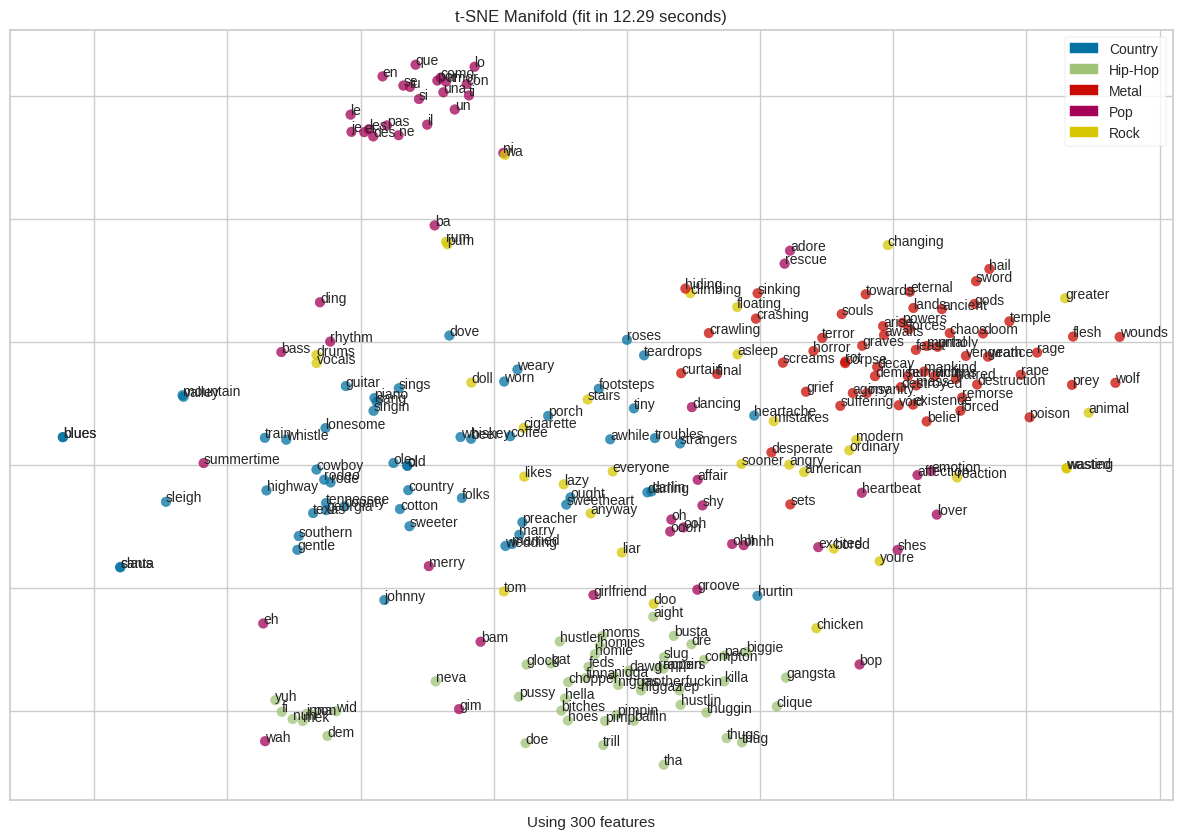

In [ ]:
cats = freq_per_genre.loc[top_50_all_genres_emb.index].idxmax(axis=1).astype('category')

fig, ax = plt.subplots(figsize=(15,10))
plot=manifold_embedding(top_50_all_genres_emb[range(300)], cats.cat.codes, manifold="tsne", n_neighbors=10, classes=cats.cat.categories, ax=ax, show=False)


for i,(x,y) in enumerate(plot.manifold.embedding_):
    ax.text(x=x,y=y,s=top_50_all_genres_emb.index[i],
            fontdict=dict(size=10),)
plt.show()

> We had a bunch of unique pop words being just words in other languages. We tried to solve it but they still have a settlement on the side of all other words.
>
> Aside from that, Hip-Hop, Metal and to a lesser extent Country seem to use unique words, while Rock and Pop mix up with each other and other genres. It makes sense in the context of pop being not as well defined thematically. Country mixing up with rock and metal also make sense due to their common roots.
>
> As for specific words, words with similar meaning seem to be close to each other: See weary\worn, whiskey/beer, flesh/corpse. In addition, see gentle/southern are words that aren't really close in meaning, but are kind of a trope in country music in particular.

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [ ]:

label_encoder = LabelEncoder()

X = CountVectorizer(
                    # tokenizer = None,
                    # token_pattern = None,
                    stop_words = list(stops),
                    lowercase=True,
                    min_df=10
                    ).fit_transform(df['sent'])

y = label_encoder.fit_transform(df['genre'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

nb = MultinomialNB().fit(X_train, y_train)

Show the confusion matrix.

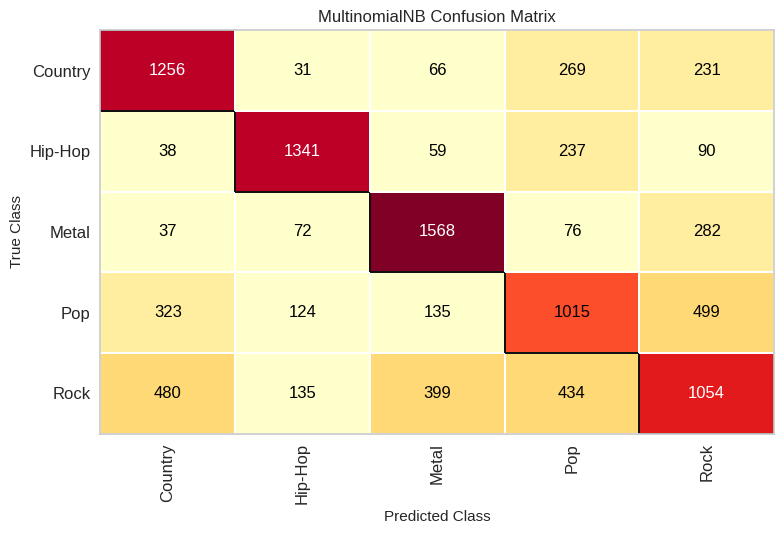

ConfusionMatrix(ax=<Axes: title={'center': 'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array(['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock'], dtype=object),
                cmap=<matplotlib.colors.ListedColormap object at 0x7f2382b754e0>,
                estimator=MultinomialNB(), is_fitted=True)

In [ ]:
confusion_matrix(nb, X_train, y_train, X_test, y_test, is_fitted=True, classes=label_encoder.classes_)

Show the classification report - precision, recall, f1 for each class.

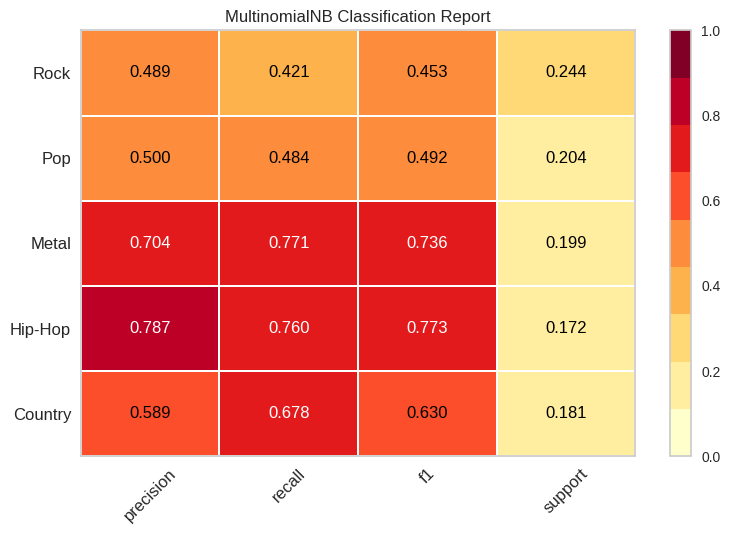

ClassificationReport(ax=<Axes: title={'center': 'MultinomialNB Classification Report'}>,
                     classes=array(['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock'], dtype=object),
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f23a40f9990>,
                     estimator=MultinomialNB(), is_fitted=True,
                     support='percent')

In [ ]:
classification_report(nb, X_train, y_train, X_test, y_test, is_fitted=True, classes=label_encoder.classes_, support='percent')

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [ ]:
clean_word_count = very_clean_words.value_counts()
unrare_clean_word_count = clean_word_count[clean_word_count.gt(50)]

word_count_per_song = (very_clean_words
                       .groupby(level=0)
                       .value_counts()
                       .reset_index(level=0, name='count')
                       .loc[unrare_clean_word_count.index]
                       .set_index('level_0', append=True)
                       .swaplevel()
                       .squeeze()
                       )
sum_of_words_per_song = (word_count_per_song
                         .groupby(level=0)
                         .sum())

word_emb_and_count_per_song = (word_count_per_song
                               .to_frame('count')
                               .reset_index(names=['song','lyrics'])
                               .merge(emb[range(300)], left_on='lyrics', right_index=True)
                               .set_index('song')
                               )

song_embedding = (word_emb_and_count_per_song[range(300)]
                  .mul(word_emb_and_count_per_song['count'], axis=0)
                  .groupby(level=0).sum()
                  .div(sum_of_words_per_song, axis=0))


In [ ]:
X = song_embedding

label_encoder = LabelEncoder()
y = df.loc[X.index, 'genre']
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

nb = GaussianNB().fit(X_train, y_train)

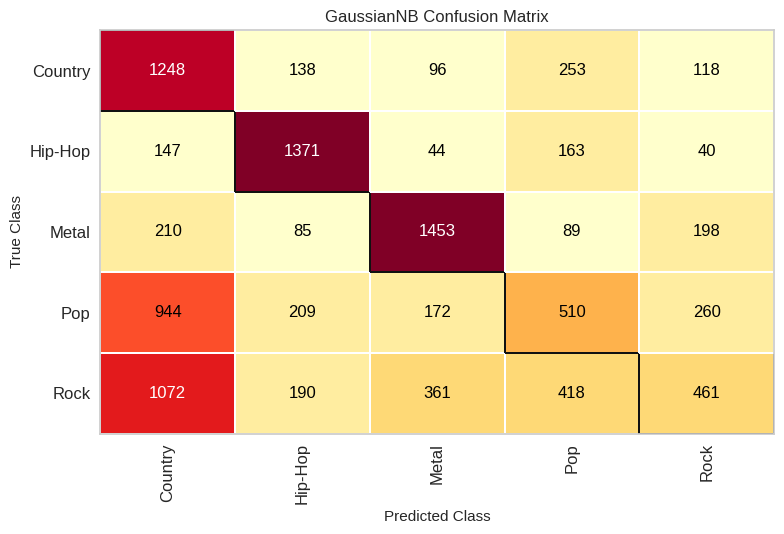

ConfusionMatrix(ax=<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array(['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock'], dtype=object),
                cmap=<matplotlib.colors.ListedColormap object at 0x7f23a41f7f70>,
                estimator=GaussianNB(), is_fitted=True)

In [ ]:
confusion_matrix(nb, X_train, y_train, X_test, y_test, is_fitted=True, classes=label_encoder.classes_)

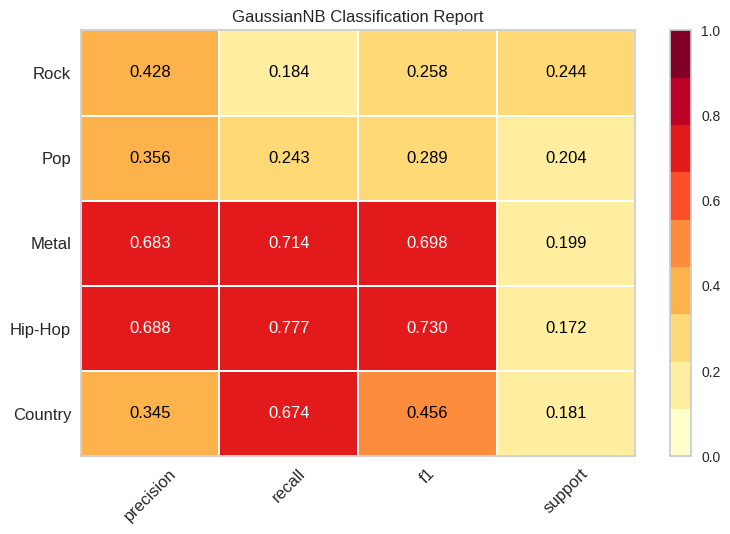

ClassificationReport(ax=<Axes: title={'center': 'GaussianNB Classification Report'}>,
                     classes=array(['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock'], dtype=object),
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f23873101c0>,
                     estimator=GaussianNB(), is_fitted=True, support='percent')

In [ ]:
classification_report(nb, X_train, y_train, X_test, y_test, is_fitted=True, classes=label_encoder.classes_, support='percent')

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [ ]:
vec = TfidfVectorizer(
    stop_words = list(stops),
    lowercase=True,
    min_df=10
)

X = vec.fit_transform(df.lyrics)
y = label_encoder.fit_transform(df['genre'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

nb = MultinomialNB().fit(X_train, y_train)

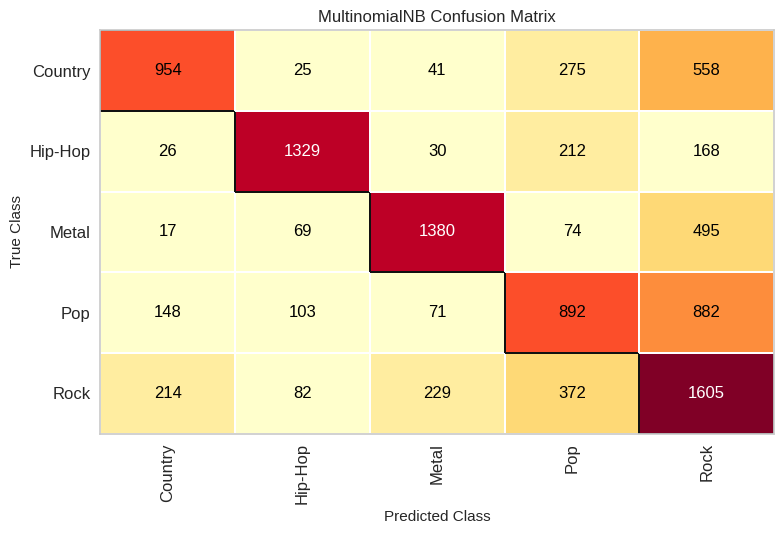

ConfusionMatrix(ax=<Axes: title={'center': 'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array(['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock'], dtype=object),
                cmap=<matplotlib.colors.ListedColormap object at 0x7f2387250730>,
                estimator=MultinomialNB(), is_fitted=True)

In [ ]:
confusion_matrix(nb, X_train, y_train, X_test, y_test, is_fitted=True, classes=label_encoder.classes_)

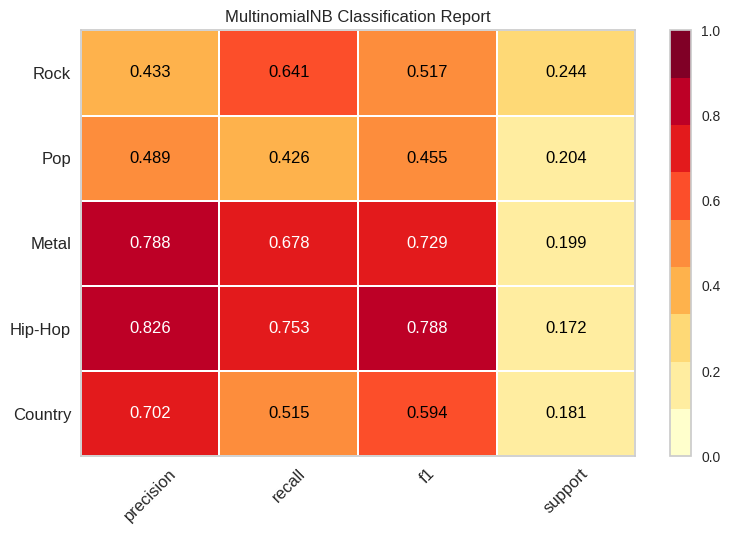

ClassificationReport(ax=<Axes: title={'center': 'MultinomialNB Classification Report'}>,
                     classes=array(['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock'], dtype=object),
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f2387250700>,
                     estimator=MultinomialNB(), is_fitted=True,
                     support='percent')

In [ ]:
classification_report(nb, X_train, y_train, X_test, y_test, is_fitted=True, classes=label_encoder.classes_, support='percent')

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try to answer this question without using papers or code examples.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper's code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might point you in the right direction for your own code solution.

> We made this network up with some inspiration from the above paper. We didn't have the time to make it work in more than a very basic way, so the results are pretty crummy.

In [ ]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummaryX import summary as summaryx

import torchvision
from torchvision import datasets, models, transforms


In [ ]:
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

class SongsDataset(Dataset):

    def tensor_and_pad(self, idx_list):
        as_tensor = torch.tensor(idx_list, dtype=int)
        missing_words = 128 - as_tensor.shape[0]
        return F.pad(as_tensor, (0, missing_words), mode='constant', value=len(self.w2v_model.wv))

    def __init__(self, very_clean_words, genres, w2v_model):

        self.w2v_model = w2v_model

        word_count = very_clean_words.value_counts()
        unrare_words = word_count[word_count.ge(10)]
        very_clean_words = very_clean_words[very_clean_words.isin(unrare_words.index)]

        self.debug = very_clean_words.groupby(level=0).head(128).map(w2v_model.wv.key_to_index).groupby(level=0, sort=False).agg(list)

        self.words = self.debug.map(self.tensor_and_pad)

        self.label_encoding = LabelEncoder()
        genres = genres.loc[self.words.index]

        self.genres = torch.tensor(self.label_encoding.fit_transform(genres) )


    def __len__(self):
        return len(self.genres)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.genres[idx]

        song_words = self.words.iat[idx]
        sample = (song_words, label)

        return sample


In [ ]:
entire_dataset = SongsDataset(very_clean_words, df['genre'], model)
indices = np.arange((len(entire_dataset)))
np.random.shuffle(indices)

n_train, n_val = np.split(indices, (len(indices)//10*6,))
# Create a dictionary of train and val datasets from images in folders
song_datasets = {'train': torch.utils.data.Subset(entire_dataset, n_train),
                 'val': torch.utils.data.Subset(entire_dataset, n_val)}


dataloaders = {
    'train': torch.utils.data.DataLoader(song_datasets['train'], batch_size=16,
                                             shuffle=False, num_workers=2),
    'val': torch.utils.data.DataLoader(song_datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=2)
  }

dataset_sizes = {x: len(song_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 24600, 'val': 16402}


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import time, copy
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs.view(BATCH_SIZE*SEQ_SIZE), labels.view(BATCH_SIZE*SEQ_SIZE))

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, dict_res


In [ ]:
class Net(nn.Module):
    def __init__(self, w2v):
        super(Net, self,).__init__()

        emb_weights = F.pad(torch.tensor(w2v.wv.vectors), (0,0, 0,1), value=0,)

        self.embed = nn.Embedding.from_pretrained(emb_weights, freeze=True, padding_idx=len(w2v.wv))

        self.stuff = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=128, kernel_size=11),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=5),

                nn.Conv2d(in_channels=128, out_channels=5, kernel_size=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=5),

                nn.Flatten(),
                nn.Linear(220, 5),
            )

    def forward(self, x):
        x = self.embed(x).unsqueeze(1)
        return self.stuff(x)


NameError: ignored

In [ ]:
net = Net(model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=0.001,)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10

net,dict_res = train_model(net.to(device),
                        dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)